In [ ]:
#%tensorflow_version 1.x

In [2]:
! pip install keras-unet

In [31]:
import os
import sys
import glob
#import h5py
import albumentations as A
from keras_unet.utils import get_augmented
from PIL import Image
from pathlib import Path
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.io import imshow
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from skimage.morphology import label
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, SpatialDropout2D, Concatenate, ZeroPadding2D, concatenate
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras_unet.utils import plot_imgs
from keras_unet.models import vanilla_unet, custom_unet
from keras.optimizers import Adam, SGD
from keras_unet.metrics import iou, iou_thresholded
import tensorflow as tf
import cv2


IMG_WIDTH = 512
IMG_HEIGHT = 512
#IMG_CHANNELS = 3
TRAIN_PATH = '/content/drive/MyDrive/hydra/train'
TEST_PATH = '/content/drive/MyDrive/hydra/test'

# to supress warnings from skimage
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
plt.rcParams["axes.grid"] = False

## Load Train and Test Data

In [2]:
def load_data(train_path, test_path):
    print("Getting and resizing data!")
    train_X = sorted(Path(train_path + '/images').glob('*.tif'))
    train_Y = sorted(Path(train_path + '/masks').glob('*.tif'))
    print(f"Found {len(train_X)} training images and {len(train_Y)} masks.")

    test_X = sorted(Path(test_path + '/images').glob('*.tif'))
    test_Y = sorted(Path(test_path + '/masks').glob('*.tif'))
    print(f"Found {len(test_X)} testing images and {len(test_Y)} masks.")
    sys.stdout.flush()
    
    # create arrays to store the resized train images
    X_train = np.zeros((len(train_X), IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS), dtype=np.uint8)
    Y_train = np.zeros((len(train_Y), IMG_WIDTH, IMG_HEIGHT, 1), dtype=bool)
    
    print("Resizing train images...")
    sys.stdout.flush()
    for num, image in tqdm(enumerate(train_X), total=len(train_X)):
        # convert to gray-scale
        img = np.array(Image.open(image).convert('RGB'))
        img = resize(img, (IMG_WIDTH, IMG_HEIGHT), mode='constant', preserve_range=True)
        X_train[num] = img

    for num, image in tqdm(enumerate(train_Y), total=len(train_Y)):
        img = np.array(Image.open(image).convert('L'))
        h, w = img.shape
        img = img.reshape(h, w, 1)
        img = resize(img, (IMG_WIDTH, IMG_HEIGHT), mode='constant', preserve_range=True)
        Y_train[num] = img

    # create arrays to store the resized test images
    X_test = np.zeros((len(test_X), IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS), dtype=np.uint8)
    Y_test = np.zeros((len(test_Y), IMG_WIDTH, IMG_HEIGHT, 1), dtype=bool)

    print("Resizing test images...")
    sys.stdout.flush()
    #sizes_test = []
    for num, image in tqdm(enumerate(test_X), total=len(test_X)):
        img = np.array(Image.open(image).convert('RGB'))
        #sizes_test.append([im.shape[0], im.shape[1]])
        img = resize(img, (IMG_WIDTH, IMG_HEIGHT), mode='constant', preserve_range=True)
        X_test[num] = img

    for num, image in tqdm(enumerate(test_Y), total=len(test_Y)):
        img = np.array(Image.open(image).convert('L'))
        h, w = img.shape
        img = img.reshape(h, w, 1)
        img = resize(img, (IMG_WIDTH, IMG_HEIGHT), mode='constant', preserve_range=True)
        Y_test[num] = img
    print("Completed the data loading and resizing!")
    sys.stdout.flush()



    return X_train, Y_train, X_test, Y_test

In [3]:
X_train, Y_train, X_test, Y_test = load_data(TRAIN_PATH, TEST_PATH)

Getting and resizing data!
Found 24 training images and 24 masks.
Found 6 testing images and 6 masks.
Resizing train images...


100%|██████████| 24/24 [00:03<00:00,  6.73it/s]

Resizing test images...



100%|██████████| 6/6 [00:00<00:00,  6.90it/s]

Completed the data loading and resizing!


In [4]:
print(f"Train image shape: {X_train.shape}")
print(f"Test image shape: {X_test.shape}")

Train image shape: (24, 512, 512, 3)
Test image shape: (6, 512, 512, 3)


In [5]:
print(f"Train mask shape: {Y_train.shape}")
print(f"Test mask shape: {Y_test.shape}")

Train mask shape: (24, 512, 512, 1)
Test mask shape: (6, 512, 512, 1)


## Inspect a few train images

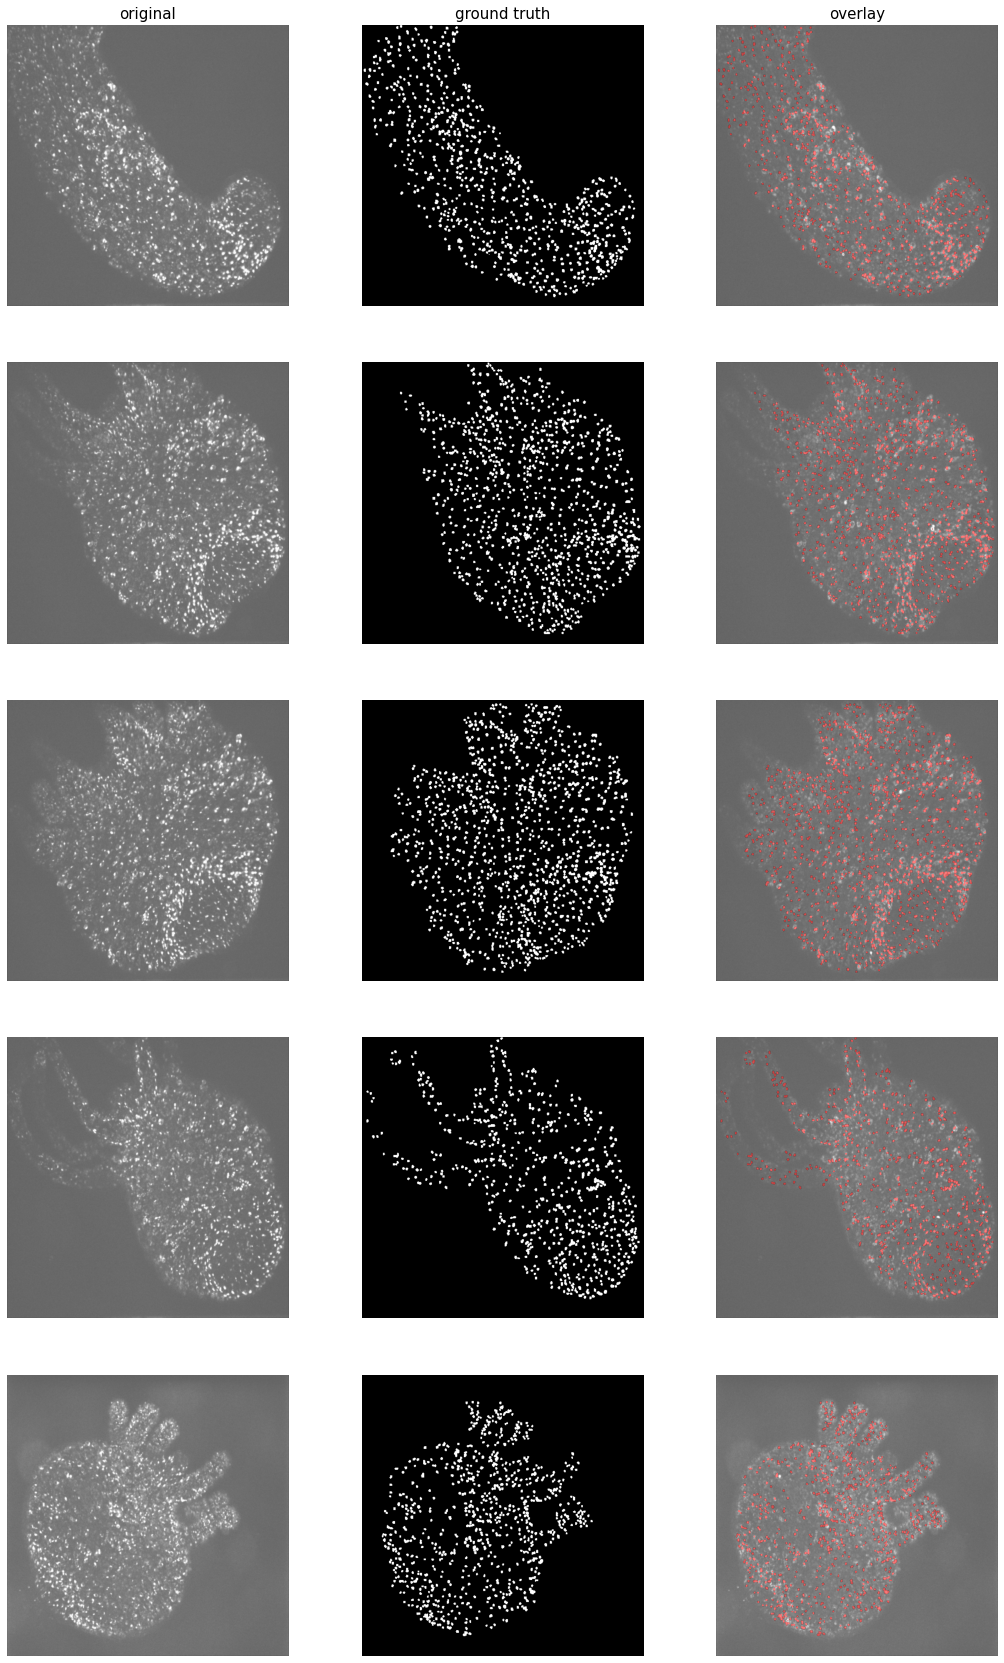

In [6]:
plot_imgs(org_imgs=X_train, mask_imgs=Y_train, nm_img_to_plot=5, figsize=6)

## Data Augmentation

In [7]:
aug = A.Compose([
      A.Flip(always_apply=True),
      A.Rotate(limit=45, always_apply=True),
      A.GaussNoise(p=0.5),
      A.RandomBrightnessContrast(p=0.5),
      A.OneOf([
        A.ElasticTransform(p=0.4, alpha= 30, sigma = 30*0.5),
        A.GridDistortion(p=0.6),
        ], p=0.5)
])

In [8]:
def augment_data(augmentation, X_train, Y_train, iters):
  images, masks = [],[]

  Y_train = Y_train.astype(np.uint8)
  train_data = zip(X_train, Y_train)
  for _, (x,y) in tqdm(enumerate(train_data)):
    for i in range(iters):
      augmented = augmentation(image=x, mask=y)
      images.append(augmented['image'])
      masks.append(augmented['mask'])

  X_aug = np.array(images, dtype=np.uint8)
  Y_aug = np.array(masks, dtype=bool)

  return X_aug, Y_aug

In [9]:
X_aug, Y_aug = augment_data(aug, X_train, Y_train, 50)

24it [01:09,  2.91s/it]


### Let's check a sample image!

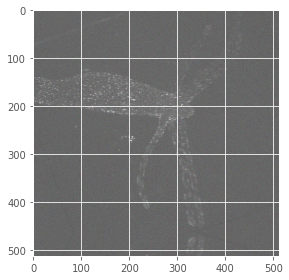

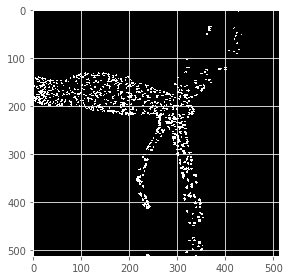

In [30]:
ix = random.randint(0, X_aug.shape[0])
imshow(X_aug[ix])
plt.show()
imshow(np.squeeze(Y_aug[ix]))
plt.show()

In [13]:
X_train, X_val, Y_train, Y_val = train_test_split(X_aug, Y_aug, test_size=0.3, random_state=0)

print(f"Train image shape: {X_train.shape}")
print(f"Val image shape: {X_val.shape}")

print(f"Train mask shape: {Y_train.shape}")
print(f"Val mask shape: {Y_val.shape}")

Train image shape: (840, 512, 512, 3)
Val image shape: (360, 512, 512, 3)
Train mask shape: (840, 512, 512, 1)
Val mask shape: (360, 512, 512, 1)


# Train UNet Model

In [14]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[iou])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 512, 512, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

# Fit the Model

### Vanilla U-Net

In [21]:
input_shape = X_train[0].shape

model = vanilla_unet(
    input_shape = input_shape,
    num_classes = 1,
    dropout = 0.2,
    filters = 64,
    num_layers = 4,
    output_activation = 'sigmoid'
)

### Attention U-Net

In [13]:
input_shape = X_train[0].shape

model = custom_unet(
    input_shape = input_shape,
    use_batch_norm=False,
    num_classes=1,
    filters=64,
    dropout=0.2,
    use_attention=False,
    output_activation='sigmoid'
)

### Start Training!

In [22]:
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[iou, iou_thresholded])
es = EarlyStopping(patience=3, verbose=1)
model_filename = 'hydra_vanilla_v0.h5'
cb = ModelCheckpoint(
    model_filename, 
    verbose=1, 
    monitor='val_loss', 
    save_best_only=True,
)

In [23]:
results = model.fit(X_train, Y_train, batch_size=2, validation_data=(X_val, Y_val),
                    epochs=30, callbacks=[es, cb])

Epoch 1/30


ValueError: ignored

# Plot Training Results

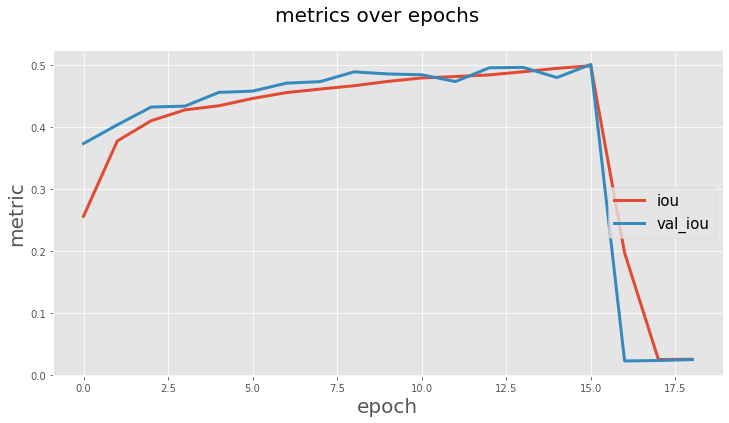

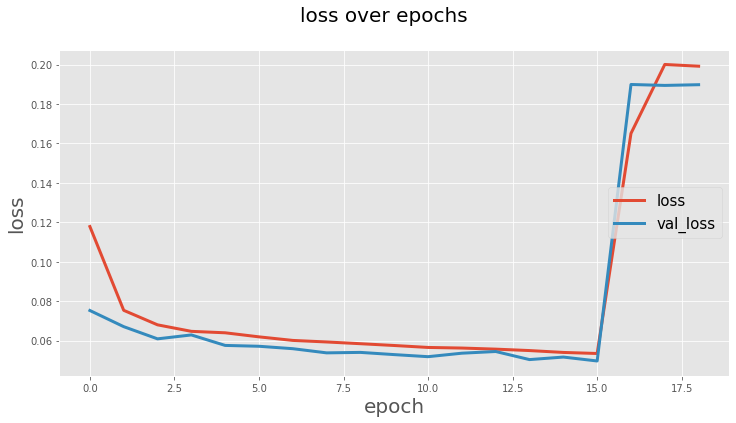

In [17]:
from keras_unet.utils import plot_segm_history
plt.style.use('ggplot')

plot_segm_history(results)

In [18]:
# get predictions on the val set
y_pred = model.predict(X_val)

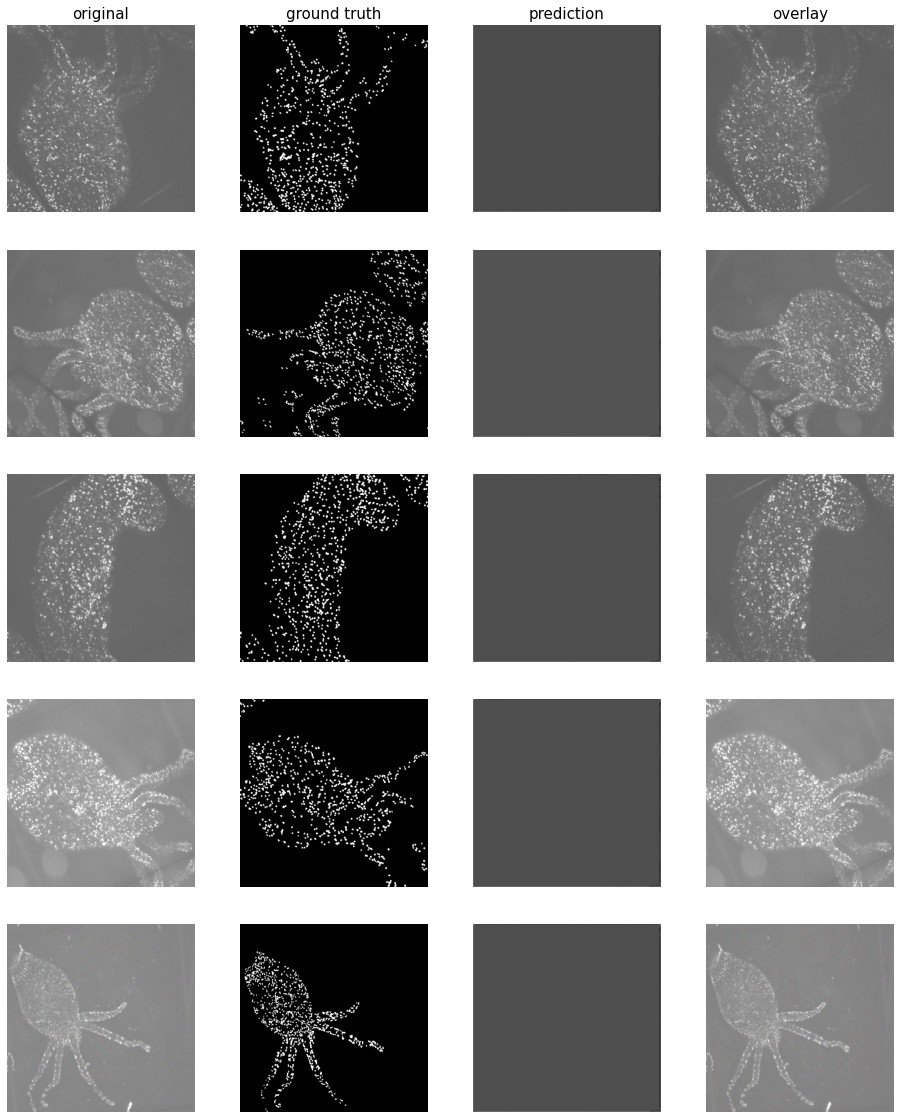

In [19]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=X_val, mask_imgs=Y_val, pred_imgs=y_pred, nm_img_to_plot=5)

# Make Predictions

In [ ]:
#! pip install 'h5py==2.10.0' --force-reinstall

     |████████████████████████████████| 2.9 MB 8.3 MB/s 
     |████████████████████████████████| 15.7 MB 127 kB/s 
  Attempting uninstall: six
    Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lucid 0.3.10 requires umap-learn, which is not installed.
tensorflow 1.15.2 requires gast==0.2.2, but you have gast 0.4.0 which is incompatible.
lucid 0.3.10 requires numpy<=1.19, but you have numpy 1.21.1 which is incompatible.
kapre 0.3.5 requires tensorflow>=2.0.0, but

In [ ]:
model = load_model('/content/myhydramodel_mean_iou', custom_objects={'mean_iou': mean_iou})

In [ ]:
# Predict on train, val and test
#preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
#preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
#preds_train_t = (preds_train > 0.5).astype(np.uint8)
#preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

Cause: could not parse the source code of <function <lambda> at 0x7f3ff029f710>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7f3ff029f710>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 28s 28s/step


In [ ]:
def precision_at(threshold, iou):
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1   # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
    return tp, fp, fn

In [ ]:
preds_test[1]

array([[[0.16805242],
        [0.02838941],
        [0.02328361],
        ...,
        [0.01136481],
        [0.02633647],
        [0.04722516]],

       [[0.04551805],
        [0.00946804],
        [0.00443192],
        ...,
        [0.00392009],
        [0.00912257],
        [0.02613533]],

       [[0.02440469],
        [0.01151134],
        [0.00539636],
        ...,
        [0.0078985 ],
        [0.00468831],
        [0.03981724]],

       ...,

       [[0.02856646],
        [0.00769351],
        [0.00325912],
        ...,
        [0.03898262],
        [0.01236462],
        [0.10009931]],

       [[0.0325729 ],
        [0.02586342],
        [0.00875362],
        ...,
        [0.00820053],
        [0.02698678],
        [0.0889556 ]],

       [[0.09143943],
        [0.0428515 ],
        [0.07048035],
        ...,
        [0.12132252],
        [0.11944842],
        [0.31934324]]], dtype=float32)

In [ ]:
Y_test.shape

(6, 1600, 1600, 1)

In [ ]:
matches = preds_test_t
# get correct objects
true_positives = np.sum(matches, axis=1) == 1
false_positives = np.sum(matches, axis=1) == 0
false_negatives = np.sum(matches, axis=0) == 0

In [ ]:
tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)

In [ ]:
precision = tp / (tp + fp)
recall = tp / (tp + fn)

print(f"Precision: {precision}")
print(f"Recall: {recall}")

Precision: 0.034028203556100554
Recall: 4.583562683523166e-05


In [ ]:
prec = []
for tau in np.arange(0.5, 1, 0.1):
  tp, fp, fn = precision_at(tau, ious)
  if (tp + fp + fn) > 0:
    p = tp / (tp + fp + fn)
  else:
      p = 0
  prec.append(p)

AxisError: ignored

In [ ]:
def compute_IoU(ground_truth, prediction):
    """ This function computes the intersection over union between the ground-truth
        mask and the predicted labels.

        Arguments:
            - ground_truth [numpy]: an array representation of all the ground-truth masks
            - prediction [numpy]: an array representation of the predicted labels
        Returns:
            - iou [float]: the intersection over union, rounded to two decimal places
    
    """
    intersection = np.logical_and(ground_truth, prediction)
    union = np.logical_or(ground_truth, prediction)
    iou = round(np.sum(intersection) / np.sum(union), 2)

    return iou

In [ ]:
pred_10x = np.squeeze(preds_test_t[0]).reshape(1600, 1600, 1)
pred_4x = np.squeeze(preds_test_t[2]).reshape(1600, 1600, 1)
pred_6x = np.squeeze(preds_test_t[3]).reshape(1600, 1600, 1)

In [ ]:
compute_IoU(Y_test[0], pred_10x)

0.55

In [ ]:
compute_IoU(Y_test[2], pred_4x)

0.38

In [ ]:
compute_IoU(Y_test[3], pred_6x)

0.28

In [ ]:
compute_IoU()

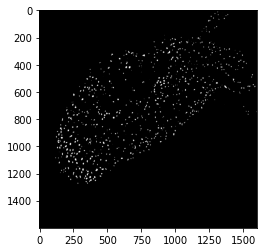

In [ ]:
plt.imshow(np.squeeze(preds_test_t[0]), cmap='gray')
plt.savefig('mymodel_pred_10x', dpi=400)

In [ ]:
def show_plane(ax, plane, cmap="gray", title=None):
    ax.imshow(plane, cmap=cmap)
    ax.axis("off")

    if title:
        ax.set_title(title)

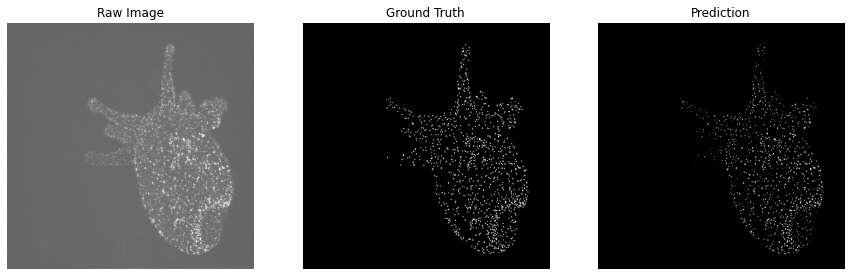

In [ ]:
 _, (a, b, c) = plt.subplots(ncols=3, figsize=(15, 5))

ix = random.randint(0, len(preds_test_t))
show_plane(a, X_test[ix], title='Raw Image')
show_plane(b, np.squeeze(Y_test[ix]), title='Ground Truth')
show_plane(c, np.squeeze(preds_test_t[ix]), title='Prediction')

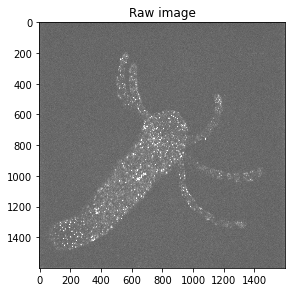

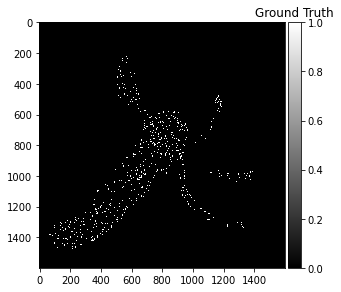

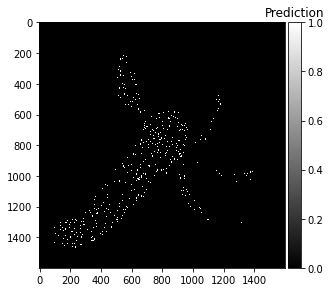

In [ ]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_test_t))
imshow(X_test[ix])
plt.title('Raw image')
plt.show()

imshow(np.squeeze(Y_test[ix]), cmap='gray')
plt.title('Ground Truth')
plt.show()

imshow(np.squeeze(preds_test_t[ix]), cmap='gray')
plt.title('Prediction')
plt.show()

In [ ]:
from keras.metrics import MeanIoU
num_classes = 2

IoU_keras = MeanIoU(num_classes=2)
IoU_keras.update_state(Y_test, preds_test)
mean_iou = IoU_keras.result().numpy()
print(f"Mean IoU is {mean_iou}")



RuntimeError: ignored

In [ ]:
# to calculate IoU for each class...
values = np.array(IoU_keras.get_weights()).reshape(num_classes, num_classes)

NameError: ignored

In [ ]:
def load_image(filename):
    """ This function loads a mask image.
        
        Arguments:
            - filename [str]: the path to the imagefile
        Returns:
            - img [numpy]: an array representation of the grayscale image
    """

    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    

    return img

In [ ]:
def get_mask_region(img):
    """ This function computes the pixel area of the specified mask.
        
        Arguments:
            - img [numpy]: an array representation of the mask
        Returns:
            - mask [numpy]: an array containing the regions for each neuron mask,
                            which are localized by detecting the connected components
    """

    labels = measure.label(img, connectivity=None, background=0)
    mask = np.zeros(img.shape, dtype="uint8")

    for label in np.unique(labels):
        if label == 0:
            continue
        else:
            labelMask = np.zeros(img.shape, dtype="uint8")
            labelMask[labels == label] = 255
            mask = cv2.add(mask, labelMask)

    return mask

In [ ]:
from skimage import measure
import cv2

predicted_img = load_image('pred.tif')
pred_area = get_mask_region(predicted_img)

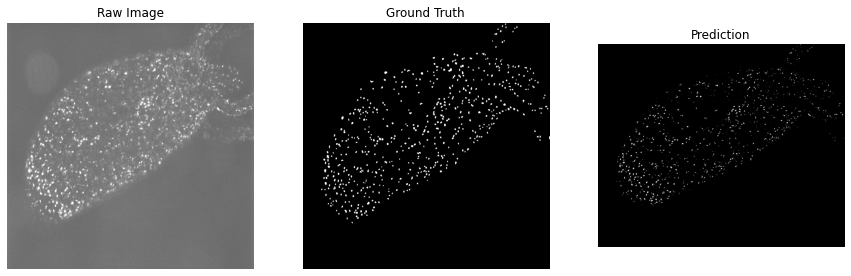

In [ ]:
 _, (a, b, c) = plt.subplots(ncols=3, figsize=(15, 5))

#ix = random.randint(0, len(preds_test_t))
show_plane(a, X_test[0], title='Raw Image')
show_plane(b, np.squeeze(Y_test[0]), title='Ground Truth')
show_plane(c, pred_area, title='Prediction')